# 2020.07.27 VAE Tutorial
#### TA : Taewook Nam @ MLAI (namsan@kaist.ac.kr)

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

from tqdm import trange


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Task 1 : Implementation of VAE

### 1) Implement neural network encoder & decoder

In [5]:
class VAE(Model):
  h_dim = 500

  def __init__(self, x_shape, z_dim):
    super().__init__()

    x_dim = np.prod(x_shape)
    self.z_dim = z_dim

    self.encoder = Sequential([
        Flatten(),
        Dense(self.h_dim, activation='relu'),
        Dense(self.h_dim, activation='relu'),
    ])
    self.mu_dense = Dense(z_dim)
    self.sigma_dense = Dense(z_dim, activation='softplus')

    self.decoder = Sequential([
        Dense(self.h_dim, activation='relu'),
        Dense(self.h_dim, activation='relu'),
        Dense(x_dim, activation='sigmoid'),
        Reshape(x_shape)
    ])

  def encode(self, x):
    h = self.encoder(x)
    z_mu = self.mu_dense(h)
    z_sigma = self.sigma_dense(h)
    return z_mu, z_sigma

  def decode(self, z):
    return self.decoder(z)

vae = VAE((28, 28), 2)

### 2) Implement loss function

In [6]:
@tf.function
def compute_elbo(x, x_reconst, z_mu, z_sigma):
  log_likelihood = tf.reduce_sum(
    x*tf.math.log(x_reconst+1e-6) + (1-x)*tf.math.log(1-x_reconst+1e-6),
    axis=(1,2)
  )
  kl = 0.5 * tf.reduce_sum(
    z_mu**2 + z_sigma**2 - tf.math.log(z_sigma**2) - 1,
    axis=1
  )
  elbo = tf.reduce_mean(log_likelihood - kl)
  return elbo

### 3) Prepare data (MNIST)

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.cast(x_train / 255.0, tf.float32)
x_test = tf.cast(x_test / 255.0, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(100)### 3) Train VAE

### 4) Optimize VAE

In [8]:
optimizer = tf.keras.optizzmizers.Adam()

In [9]:
for epoch_i in trange(100):
  for x in train_ds:
    with tf.GradientTape() as tape:
      z_mu, z_sigma = vae.encode(x)
      z_dist = tfp.distributions.Normal(z_mu, z_sigma)
      z = z_dist.sample()
      x_reconst = vae.decode(z)
        
      elbo = compute_elbo(x, x_reconst, z_mu, z_sigma)
      loss = -elbo
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

  if (epoch_i+1) % 5 == 0:
    vae.save_weights(f'ckpt/{epoch_i + 1}')

8%|▊         | 8/100 [00:41<07:57,  5.19s/it]


KeyboardInterrupt: 

In [11]:
ckpt_i = 100
vae.load_weights(f'ckpt/{ckpt_i}')

# Task 2: Visualize encodings

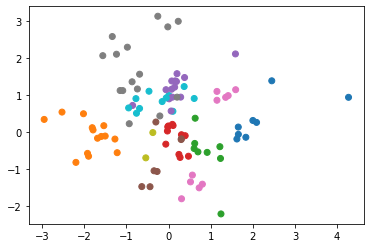

In [12]:
n_points = 100
z_mu, _ = vae.encode(x_test[:n_points])

fig, ax = plt.subplots()
scatter = plt.scatter(
    z_mu[:, 0], z_mu[:, 1],
    c=[f'C{y_test[i]}' for i in range(n_points)],
    label=[y_test[i] for i in range(n_points)]
)

# Task 3: Visualize reconstructed images

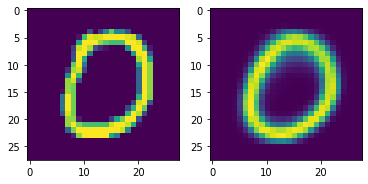

In [14]:
idx = 10
z_mu, _ = vae.encode(x_test)
x_reconst = vae.decode(z_mu)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_test[idx])
ax2.imshow(x_reconst[idx])

# Task 4: Visualize learned latent space

In [15]:
z_range = np.arange(-1, 1, 0.1)
z_grid = np.stack(np.meshgrid(z_range, z_range), axis=-1)

z_grid_flat = z_grid.reshape(400, 2)
x_reconst_flat = vae.decode(tf.convert_to_tensor(z_grid_flat))
x_reconst = x_reconst_flat.numpy().reshape(20, 20, 28, 28)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.5, 559.5, 559.5, -0.5)

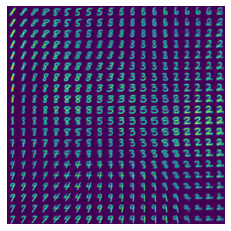

In [16]:
x_merged = x_reconst.swapaxes(1, 2).reshape(20*28, 20*28)
plt.imshow(x_merged)
plt.axis('off')